# Model rozpoznający fake news

# Wstępne ustawienia

In [1]:
!pip install torchsummaryX matplotlib tqdm wordcloud ipywidgets widgetsnbextension scikit-learn seaborn transformers

## Import bibliotek

In [2]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import torch
import string
import requests
import transformers

from datetime import datetime
from tqdm import tqdm
from torchsummaryX import summary
from torch.utils import tensorboard
from random import randrange
from sklearn.metrics import confusion_matrix

## Zdefiniowanie stałych

In [3]:
NIGHTLY = False
USE_MPS = False

LOGS_PATH = 'logi/FakeNews'
DATA_PATH = 'data/FakeNews'
GRAPH_PATH = 'graph/FakeNews'
PROJECTOR_PATH = 'projector/FakeNews'
MODEL_PATH = 'model/FakeNews'
DATA_FILENAME = 'WelFake.csv'

DATA_URL = 'https://zenodo.org/record/4561253/files/WELFake_Dataset.csv?download=1'

In [4]:
TRAIN_LEN_SPLIT = 0.7
VAL_LEN_SPLIT = 0.1
TEST_LEN_SPLIT = 0.2

tmpSum = (TRAIN_LEN_SPLIT + VAL_LEN_SPLIT + TEST_LEN_SPLIT)
assert(tmpSum <= 1.0)
assert(tmpSum > 0)

## Ustawienie rozszerzeń notebooka

In [5]:
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


## Wybór urządzenia do treningu

In [6]:
if torch.cuda.is_available():
  DEVICE = torch.device('cuda')
elif torch.backends.mps.is_available() and USE_MPS:
  DEVICE = torch.device('mps')
else:
  DEVICE = torch.device('cpu')

## Utworzenie potrzebnych katalogów

In [7]:
list_folders = [
  LOGS_PATH,
  DATA_PATH,
  PROJECTOR_PATH,
  MODEL_PATH
]

for x in list_folders:
  if not os.path.exists(x):
    os.makedirs(x)

# Zbiór danych
Pobrane z
https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification

## Funkcja pobierająca CSV from URL_PATH save to DATA_PATH

In [8]:
def download_csv(url: string, file_path: string, filename: string):
  req = requests.get(url)
  body = req.content

  with open(os.path.join(file_path, filename), 'wb') as f:
    f.write(body)

## Pobranie pliku CSV i zapisanie go do pliku

In [9]:
if not os.path.exists(os.path.join(DATA_PATH, DATA_FILENAME)):
  download_csv(DATA_URL, DATA_PATH, DATA_FILENAME)

## Wczytanie pobranego pliku do pandas

In [10]:
data = pd.read_csv(os.path.join(os.path.join(DATA_PATH, DATA_FILENAME)))
# data = pd.read_csv(DATA_URL)

### Zmiana nazwy pól

In [11]:
data = data.rename(columns={'Unnamed: 0': 'ID'})
data['category'] = np.where(data['label'] == 1, 'fake', 'real')
data.head()

,ID,title,text,label,category
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,fake
1,1,NaN,Did they post their votes for Hillary already?,1,fake
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,fake
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,real
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,fake


### Usunięcie wierszy bez artykułu

In [12]:
data = data.replace(r'^\s*$', np.nan, regex=True)
data = data.dropna(subset=['text'])

### Podsumowanie liczby artykułów z podziałem na kategorie

1 - Fake<br>0 - Real

## Podział zbioru danych


Zbiór danych zostanie podzielony na 3 zbiory:
- treningowe — dane do uczenia
- walidacyjne — do oceny modelu podczas treningu
- testowe - do oceny modelu po treningu

Dane zostaną podzielone zgodnie ze zdefiniowanym stosunkiem

In [13]:
data_train = data[:int(len(data)*TRAIN_LEN_SPLIT)]

data_val = data[
  int(len(data)*TRAIN_LEN_SPLIT):int(len(data)*TRAIN_LEN_SPLIT + len(data)*VAL_LEN_SPLIT)
]

data_test = data[
  int(len(data)*TRAIN_LEN_SPLIT + len(data)*VAL_LEN_SPLIT)
  :
  int(len(data)*TRAIN_LEN_SPLIT + len(data)*VAL_LEN_SPLIT + len(data)*TEST_LEN_SPLIT)
]

### Sprawdzenie rozmiaru poszczególnych zbiorów

#### Zbiór treningowy

In [14]:
data_train.shape

(49945, 5)

#### Zbiór walidacyjny

In [15]:
data_val.shape

(7135, 5)

#### Zbiór testowy

In [16]:
data_test.shape

(14271, 5)

# Trening modelu

## Zdefiniowanie ustawień

In [17]:
MODEL_TRANSFER_VERSION = 'bert'
MODEL_TRANSFER_PATH = os.path.join(os.path.join(MODEL_PATH, f'model_{MODEL_TRANSFER_VERSION}.pt'))

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

SEQ_LENGTH = 400

PATIENCE = 10
DELTA = 0

BATCH_SIZE = 16
EPOCHS = 100
CLIP_GRAD = 15
DROPOUT = 0.4

TOKENIZER = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

## Utworzenie klas pomocniczych

### Klasa EarlyStoping

Klasa pozwalająca zatrzymać trenowanie modelu, jeżeli model nie będzie uczył się dla zbioru walidacyjne.

In [18]:
class EarlyStoping:
  def __init__(self, patience, delta = 0, operator = np.less, model_path = None):
    self.PATIENCE = patience
    self.DELTA = delta
    self.operator = operator
    self.model_path = model_path

    self.trigger = 0
    self.best_score = None
        
  def continue_training(self, actual_value, model_save):
    if self.best_score is not None and self.operator(self.best_score + self.DELTA, actual_value):
      self.trigger += 1
            
      if self.trigger >= self.PATIENCE:
        return False
    else:
      self.trigger = 0
      self.best_score = actual_value
      if self.model_path is not None and model is not None:
        torch.save(model_save.state_dict(), self.model_path)
    return True

### Funkcja tworząca logger TensorBoard

In [19]:
def get_tensorboard_writer():
  path = os.path.join(LOGS_PATH, f'{datetime.now().strftime("%Y_%m_%d-%H_%M_%S")}_v{MODEL_TRANSFER_VERSION}')
  writer_tmp = tensorboard.SummaryWriter(path)
  
  for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    if os.path.isfile(file_path) or os.path.islink(file_path):
      os.unlink(file_path)
    
  return writer_tmp

### Przygotowanie klasy Dataset

In [20]:
class FakeNewsDataset(torch.utils.data.Dataset):
  def __init__(self, text, fake, tokenizer, max_len):
    self.text = text
    self.fake = fake
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.text)
  
  def __getitem__(self, i):
    text = str(self.text[i])
    fake = self.fake[i]
    
    enc = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_len,
      truncation=True,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt'
    )
    
    return {
      'text': text,
      'input_ids': enc['input_ids'].flatten(),
      'attention_mask': enc['attention_mask'].flatten(),
      'fake': torch.tensor(fake, dtype=torch.long)
    }

## Przygotowanie danych do treningu modelu w PyTorch

### Utworzenie tensorów dla wczytanych zbiorów

In [21]:
train_data = FakeNewsDataset(
  data_train.text.to_numpy(),
  data_train.label.to_numpy(),
  TOKENIZER,
  max_len=SEQ_LENGTH
)

val_data = FakeNewsDataset(
  data_val.text.to_numpy(),
  data_val.label.to_numpy(),
  TOKENIZER,
  max_len=SEQ_LENGTH
)

test_data = FakeNewsDataset(
  data_test.text.to_numpy(),
  data_test.label.to_numpy(),
  TOKENIZER,
  max_len=SEQ_LENGTH
)

### Stworzenie DataLoader

In [22]:
train_loader = torch.utils.data.DataLoader(
  train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
  val_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True, num_workers=4
)
test_loader = torch.utils.data.DataLoader(
  test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True, num_workers=4
)

## Definicja modelu

In [23]:
class Net(torch.nn.Module):
  def __init__(self, output_size, drop=0):
    super(Net, self).__init__()
    self.output_size = output_size
    
    self.bert = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = torch.nn.Dropout(drop)
    self.fc = torch.nn.Linear(self.bert.config.hidden_size, self.output_size)
    self.sf = torch.nn.LogSoftmax(dim=1)

  def forward(self, x, m):
    out = self.bert(input_ids=x, attention_mask=m)[1]
    out = self.drop(out)
    out = self.fc(out)
    out = self.sf(out)

    return out

## Utworzenie modelu

In [24]:
model = Net(2, DROPOUT)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Przeniesienie modelu na urządzenie do treningu

In [25]:
model.to(DEVICE)

Net(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        

### Wyświetlenie modelu

In [26]:
x = next(iter(train_loader))

summary(
  model, 
  x['input_ids'].to(DEVICE),
  x['attention_mask'].to(DEVICE)
)

/home/po/anaconda3/envs/marekBaranowski/lib/python3.10/site-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: The default value of numeric_only in DataFrame.sum is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_sum = df.sum()


                                                    Kernel Shape  \
Layer                                                              
0_bert.embeddings.Embedding_word_embeddings         [768, 28996]   
1_bert.embeddings.Embedding_token_type_embeddings       [768, 2]   
2_bert.embeddings.Embedding_position_embeddings       [768, 512]   
3_bert.embeddings.LayerNorm_LayerNorm                      [768]   
4_bert.embeddings.Dropout_dropout                              -   
5_bert.encoder.layer.0.attention.self.Linear_query    [768, 768]   
6_bert.encoder.layer.0.attention.self.Linear_key      [768, 768]   
7_bert.encoder.layer.0.attention.self.Linear_value    [768, 768]   
8_bert.encoder.layer.0.attention.self.Dropout_d...             -   
9_bert.encoder.layer.0.attention.output.Linear_...    [768, 768]   
10_bert.encoder.layer.0.attention.output.Dropou...             -   
11_bert.encoder.layer.0.attention.output.LayerN...         [768]   
12_bert.encoder.layer.0.intermediate.Linear_dens

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_bert.embeddings.Embedding_word_embeddings,"[768, 28996]","[16, 400, 768]",22268928.0,22268928.0
1_bert.embeddings.Embedding_token_type_embeddings,"[768, 2]","[16, 400, 768]",1536.0,1536.0
2_bert.embeddings.Embedding_position_embeddings,"[768, 512]","[1, 400, 768]",393216.0,393216.0
3_bert.embeddings.LayerNorm_LayerNorm,[768],"[16, 400, 768]",1536.0,768.0
4_bert.embeddings.Dropout_dropout,-,"[16, 400, 768]",NaN,NaN
...,...,...,...,...
149_bert.pooler.Linear_dense,"[768, 768]","[16, 768]",590592.0,589824.0
150_bert.pooler.Tanh_activation,-,"[16, 768]",NaN,NaN
151_drop,-,"[16, 768]",NaN,NaN


### Wczytanie wytrenowanego modelu

In [27]:
if os.path.exists(MODEL_TRANSFER_PATH):
  model.load_state_dict(torch.load(MODEL_TRANSFER_PATH))

### Kompilacja modelu

W najnowszych wersjach treningu kompilacja przyśpiesza trening modelu, ale jest dostępna tylko na CUDA.

In [28]:
czas_kompilacji = None
if DEVICE.type == 'cuda' and NIGHTLY:
  start_kompilacji = datetime.now()
  model = torch.compile(model, mode='reduce-overhead')
  czas_kompilacji = datetime.now() - start_kompilacji
  
print(f'Na kompilacje modelu potrzebne było {czas_kompilacji}')

Na kompilacje modelu potrzebne było None


## Przebieg treningu

In [29]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00001)
criterion = torch.nn.functional.nll_loss
scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=len(train_loader) * EPOCHS
)
     
early_stopping = EarlyStoping(PATIENCE, delta=DELTA, operator=np.greater_equal, model_path=MODEL_TRANSFER_PATH)

writer = get_tensorboard_writer()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

start_treningu = datetime.now()
for epoch in range(EPOCHS):
  with tqdm(train_loader, unit=' batch') as tepoch:
    tepoch.set_description(f'Epoch {epoch+1}/{EPOCHS}')

    train_loss = 0
    correct = 0
    losses = []

    model.train()

    for batch_idx, d in enumerate(tepoch):
      input_ids = d['input_ids'].to(DEVICE)
      attention_mask = d['attention_mask'].to(DEVICE)
      target = d['fake'].to(DEVICE)
      
      optimizer.zero_grad()
                  
      output = model(input_ids, attention_mask)
      loss = criterion(output, target)
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), CLIP_GRAD)
      optimizer.step()
      
      losses.append(loss.item())
      predictions = torch.argmax(output, dim=1)
      correct += predictions.eq(target.view_as(predictions)).sum().detach()
      scheduler.step()
      
      # scheduler.step(np.mean(losses))

      tepoch.set_postfix({
        'loss': round(np.mean(losses), 3),
        'acc': round((correct / ((batch_idx + 1) * BATCH_SIZE)).item(), 3)
      })

    train_loss = np.mean(losses)
    acc = (correct / float(len(train_loader.dataset))).item()
  
    train_losses.append(train_loss)
    train_accuracies.append(acc)

    model.eval()
    correct = 0
    val_loss = []
        
    with torch.no_grad():
      for d in val_loader:
        input_ids = d['input_ids'].to(DEVICE)
        attention_mask = d['attention_mask'].to(DEVICE)
        target = d['fake'].to(DEVICE)
  
        output = model(input_ids, attention_mask)

        val_loss.append(criterion(output, target).item())

        predictions = torch.argmax(output, dim=1)
        correct += predictions.eq(target.view_as(predictions)).sum().detach()
    val_acc = (correct / float(len(val_loader.dataset)))
    val_accuracies.append(val_acc)

    val_losses.append(np.mean(val_loss))

    # scheduler.step(val_acc)
    
    writer.add_scalars('accuracy', {
      'train': acc,
      'validation': val_acc
    }, epoch)
        
    writer.add_scalars('loss', {
      'train': train_loss,
      'validation': np.mean(val_loss)
    }, epoch)
    
    if not early_stopping.continue_training(val_acc.item(), model):
      tepoch.write(
        f'Early stoping Epoch: {epoch+1} \
Train loss {train_loss:.5f} Train accuracy {acc:.5f} \
Val loss: {np.mean(val_loss):.5f} Val accuracy: {val_acc:.5f}'
      )
      break

#   tepoch.write(
#     f'Train loss {train_loss:.5f} Train accuracy {acc:.5f} \
# Val loss: {np.mean(val_loss):.5f} Val accuracy: {val_acc:.5f}'
#   )
writer.close()
print(f'Model wytrenował sie w {datetime.now() - start_treningu}')

Epoch 1/100: 100%|█| 3121/3121 [23:13<00:00,  2.24 batch/s, loss=0.061, acc=0.97
Epoch 2/100: 100%|█| 3121/3121 [23:18<00:00,  2.23 batch/s, loss=0.015, acc=0.99
Epoch 3/100: 100%|█| 3121/3121 [23:31<00:00,  2.21 batch/s, loss=0.007, acc=0.99
Epoch 4/100: 100%|█| 3121/3121 [23:31<00:00,  2.21 batch/s, loss=0.005, acc=0.99
Epoch 5/100: 100%|█| 3121/3121 [23:34<00:00,  2.21 batch/s, loss=0.004, acc=0.99
Epoch 6/100: 100%|█| 3121/3121 [23:33<00:00,  2.21 batch/s, loss=0.004, acc=0.99
Epoch 7/100: 100%|█| 3121/3121 [23:29<00:00,  2.21 batch/s, loss=0.002, acc=0.99
Epoch 8/100: 100%|█| 3121/3121 [23:19<00:00,  2.23 batch/s, loss=0.002, acc=0.99
Epoch 9/100: 100%|█| 3121/3121 [23:41<00:00,  2.20 batch/s, loss=0.002, acc=0.99
Epoch 10/100: 100%|██| 3121/3121 [23:18<00:00,  2.23 batch/s, loss=0.002, acc=1]
Epoch 11/100: 100%|█| 3121/3121 [23:28<00:00,  2.22 batch/s, loss=0.002, acc=0.9
Epoch 18/100: 100%|██| 3121/3121 [23:29<00:00,  2.21 batch/s, loss=0.001, acc=1]


Early stoping Epoch: 18 Train loss 0.00078 Train accuracy 0.99954 Val loss: 0.04457 Val accuracy: 0.99201
Model wytrenował sie w 7:20:57.676163


# Test modelu

## Funkcja testująca model

In [30]:
def test_model(model, criterion, loader):
  correct = 0
  test_loss = []
  
  y_predictions = []
  y_test = []

  model.eval()
  
  with torch.no_grad():
    for batch_idx, d in enumerate(tqdm(loader)):
      input_ids = d['input_ids'].to(DEVICE)
      attention_mask = d['attention_mask'].to(DEVICE)
      target = d['fake'].to(DEVICE)
  
      output = model(input_ids, attention_mask)

      test_loss.append(criterion(output, target).item())

      predictions = torch.argmax(output, dim=1)
      correct += predictions.eq(target.view_as(predictions)).sum().detach()

      y_predictions.extend(predictions)
      y_test.extend(target)
      
    test_acc = (correct / float(len(test_loader.dataset)))
  return test_loss, test_acc, torch.stack(y_predictions).cpu(), torch.stack(y_test).cpu()

## Sprawdzenie ostatniej wersji modelu na zestawie testowym

In [31]:
test_loss, test_accuracies, _, _ = test_model(model, torch.nn.functional.nll_loss, test_loader)
print(f'Test loss {np.mean(test_loss):.5f} Test acc: {(test_accuracies * 100):.5f}%')

100%|█████████████████████████████████████████| 891/891 [02:04<00:00,  7.14it/s]

Test loss 0.03125 Test acc: 99.41139%


## Wczytanie najlepszej wersji modelu

Zostanie załadowana wersja modelu, która uzyskała najniższa wartość funkcji straty

In [32]:
model.load_state_dict(torch.load(MODEL_TRANSFER_PATH))

<All keys matched successfully>

## Sprawdzenie modelu na zestawie testowym

Zostanie sprawdzany zupełnie nowy zestaw danych. Model nigdy wcześniej nie widział danych z tego zestawu

In [33]:
test_loss, test_accuracies, y_predictions, y_test = test_model(model, torch.nn.functional.nll_loss, test_loader)

print(f'Test loss {np.mean(test_loss):.5f} Test acc: {(test_accuracies * 100):.5f}%')

100%|█████████████████████████████████████████| 891/891 [01:51<00:00,  7.99it/s]


Test loss 0.02143 Test acc: 99.46745%


## Wyświetlenie macierzy pomyłek

<Axes: >

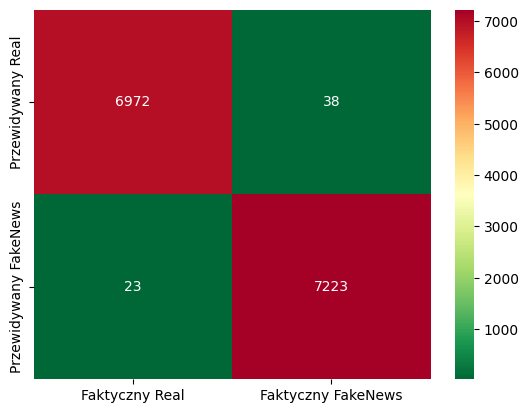

In [34]:
cf = confusion_matrix(y_predictions, y_test)
df_cm = pd.DataFrame(
  cf,
  index=[i for i in ['Przewidywany Real', 'Przewidywany FakeNews']],
  columns=[i for i in ['Faktyczny Real', 'Faktyczny FakeNews']]
)

sns.heatmap(df_cm, annot=True, cmap='RdYlGn_r', fmt='d')

## Zapisanie grafu utworzonego modelu

In [36]:
x = next(iter(train_loader))

writer_model = tensorboard.SummaryWriter(GRAPH_PATH)
writer_model.add_graph(
  model,
  (x['input_ids'].to(DEVICE), x['attention_mask'].to(DEVICE))
)

writer_model.close()

## Sprawdzenie modelu na 1 próbce

### Wybranie próbki do sprawdzenia

In [35]:
random_probe = randrange(len(data))

### Wyświetlenie wybranego artykułu

In [36]:
data[data.ID == random_probe].text

6848      I don t hate these people. They are just ang...
Name: text, dtype: object

### Sprawdzenie modelu

#### Przesłanie wybranego tekstu do modelu

In [37]:
t = TOKENIZER.encode_plus(
  data[data.ID == random_probe].text.to_numpy()[0],
  #data.text.[random_probe],
  add_special_tokens=True,
  max_length=SEQ_LENGTH,
  truncation=True,
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt'
)

output = model(
  t['input_ids'].to(DEVICE),
  t['attention_mask'].to(DEVICE)
)

#### Porównanie odpowiedzi modelu z wartością oczekiwana

In [38]:
ans_model = torch.exp(output)
print(
  f'Według modelu ten artykuł jest {"prawdziwy" if torch.argmax(ans_model) == 0 else "fałszywy"} \
i jest tego pewny na {ans_model[0][torch.argmax(ans_model)]*100:.2f}%.'
)

Według modelu ten artykuł jest prawdziwy i jest tego pewny na 100.00%.


In [39]:
print(f'Prawidłowa odpowiedz to: artykuł to {"prawda" if data.label[random_probe] == 0 else "fałsz"}.')

Prawidłowa odpowiedz to: artykuł to prawda.


In [40]:
print(
  f'Odpowiedz modelu {"nie " if torch.argmax(ans_model) != data.label[random_probe] else ""}zgadza \
sie z wartością oczekiwana.'
)

Odpowiedz modelu zgadza sie z wartością oczekiwana.
